In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

from main import main, parse_args
from utils.plotting import plot_change_responses, plot_omission_responses, plot_sequence_response
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

import os

SCRATCH = "/storage/scratch1/2/asharafeldin3"

ACTION = True

seed = np.random.randint(1001, 9999)
print(f"seed = {seed}")

seed = 9989


In [2]:
args = parse_args()

if not ACTION:
    args.perception_only = True
    args.lambda_energy = 0.5
    args.lambda_temporal = 1.0
    args.lambda_reward = 0.0
else:
    args.perception_only = False
    args.lambda_reward = 0.5
    args.lambda_temporal = 1.0
    args.lambda_energy = 10.0

args.seed = seed
args.progress_mode = 'epoch'
args.num_epochs = 250
args.train_path = os.path.join(SCRATCH, "data/allen/test")
args.test_path = os.path.join(SCRATCH, "data/allen/train")
args.calculate_dprime = True

args.batch_size = 32

model, data, output, training_progress = main(args)
Y_train, Y_test, Y_train_om, train_ts, test_ts, train_om_ts, train_oms, test_oms = data.values()
train_responses, train_responses_om, test_responses, test_om_indcs, train_om_indcs = output.values()

100%|██████████| 250/250 [11:26<00:00,  2.75s/epoch, dprime=1.69, energy=0.0823, rewards=10.7, spatial=0.187, temporal=0.0167, total=1.85, value=1.64]   


(np.float64(-0.5), np.float64(1119.5), np.float64(31.5), np.float64(-0.5))

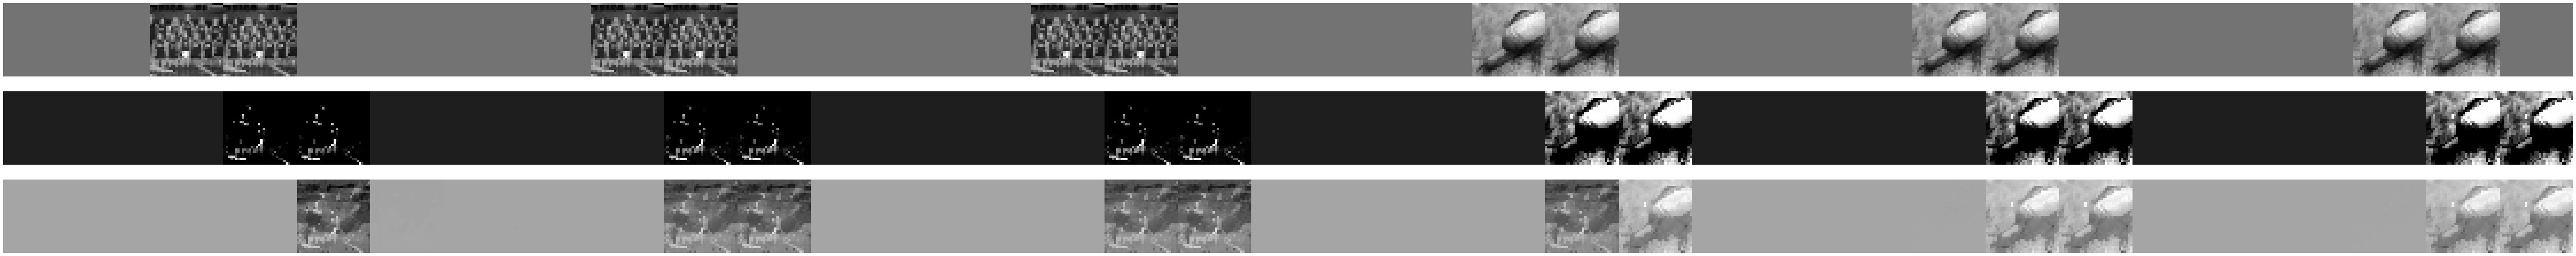

In [3]:
sidx = 11

fam_imgs_fig = plt.figure(figsize=(Y_train.shape[1] * 10, 10))

plt.subplot(3, 1, 1)
plt.imshow(torch.cat(list(Y_train[sidx, 2:37].reshape(-1, args.image_dim, args.image_dim)), dim=1).detach().cpu().numpy(), 'gray')
plt.axis("off")
#plt.title("True")

#plt.figure(figsize=(Y_train.shape[1] * 10, 4))
plt.subplot(3, 1, 2)
plt.imshow(torch.cat(list(train_responses['I_hat'][sidx, 2:37].reshape(-1,  args.image_dim,  args.image_dim)), dim=1).detach().cpu().numpy(), 'gray')
plt.axis("off")
#plt.title("Reconstructed")

train_predictions = model.reconstruction(train_responses['mu_p'][sidx])
plt.subplot(3, 1, 3)
#plt.figure(figsize=(Y_test.shape[1] * 10, 4))
plt.imshow(torch.cat(list(train_predictions[2:37].reshape(-1,  args.image_dim,  args.image_dim)), dim=1).detach().cpu().numpy(), 'gray')
plt.axis("off")
#plt.title("Predicted")

(np.float64(-0.5), np.float64(1119.5), np.float64(31.5), np.float64(-0.5))

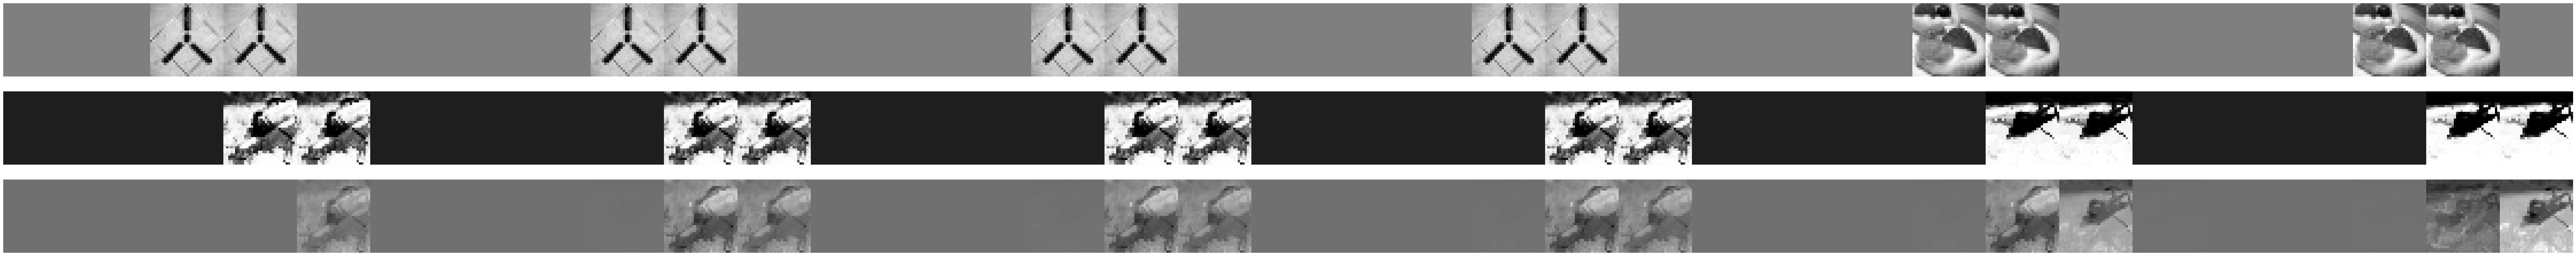

In [4]:
sidx = test_om_indcs[5]

nov_imgs_fig = plt.figure(figsize=(Y_train.shape[1] * 10, 10))

plt.subplot(3, 1, 1)
plt.imshow(torch.cat(list(Y_test[sidx, 2:37].reshape(-1, args.image_dim, args.image_dim)), dim=1).detach().cpu().numpy(), 'gray')
plt.axis("off")
#plt.title("True")

#plt.figure(figsize=(Y_train.shape[1] * 10, 4)) 
plt.subplot(3, 1, 2)
plt.imshow(torch.cat(list(test_responses['I_hat'][sidx, 2:37].reshape(-1, args.image_dim, args.image_dim)), dim=1).detach().cpu().numpy(), 'gray')
plt.axis("off")
#plt.title("Reconstructed")

test_predictions = model.reconstruction(test_responses['mu_p'][sidx])
plt.subplot(3, 1, 3)
#plt.figure(figsize=(Y_test.shape[1] * 10, 4))
plt.imshow(torch.cat(list(test_predictions[2:37].reshape(-1, args.image_dim, args.image_dim)), dim=1).detach().cpu().numpy(), 'gray')
plt.axis("off")

In [5]:
z_train, z_test = train_responses['z'], test_responses['z']
sigmap_train, sigmap_test = train_responses['sigma_p'], test_responses['sigma_p']
sigmaq_train, sigmaq_test = train_responses['sigma_q'], test_responses['sigma_q']
mup_train, mup_test = train_responses['mu_p'], test_responses['mu_p']
theta_train, theta_test = train_responses['theta'], test_responses['theta']
h_train, h_test = train_responses['h'], test_responses['h']
terror_train, terror_test = (train_responses['mu_p'] - train_responses['z'])**2, (test_responses['mu_p'] - test_responses['z'])**2

if not model.perception_only:
    value_train, value_test = train_responses['lick_value'], test_responses['lick_value']
    licks_train, licks_test = train_responses['action'], test_responses['action']

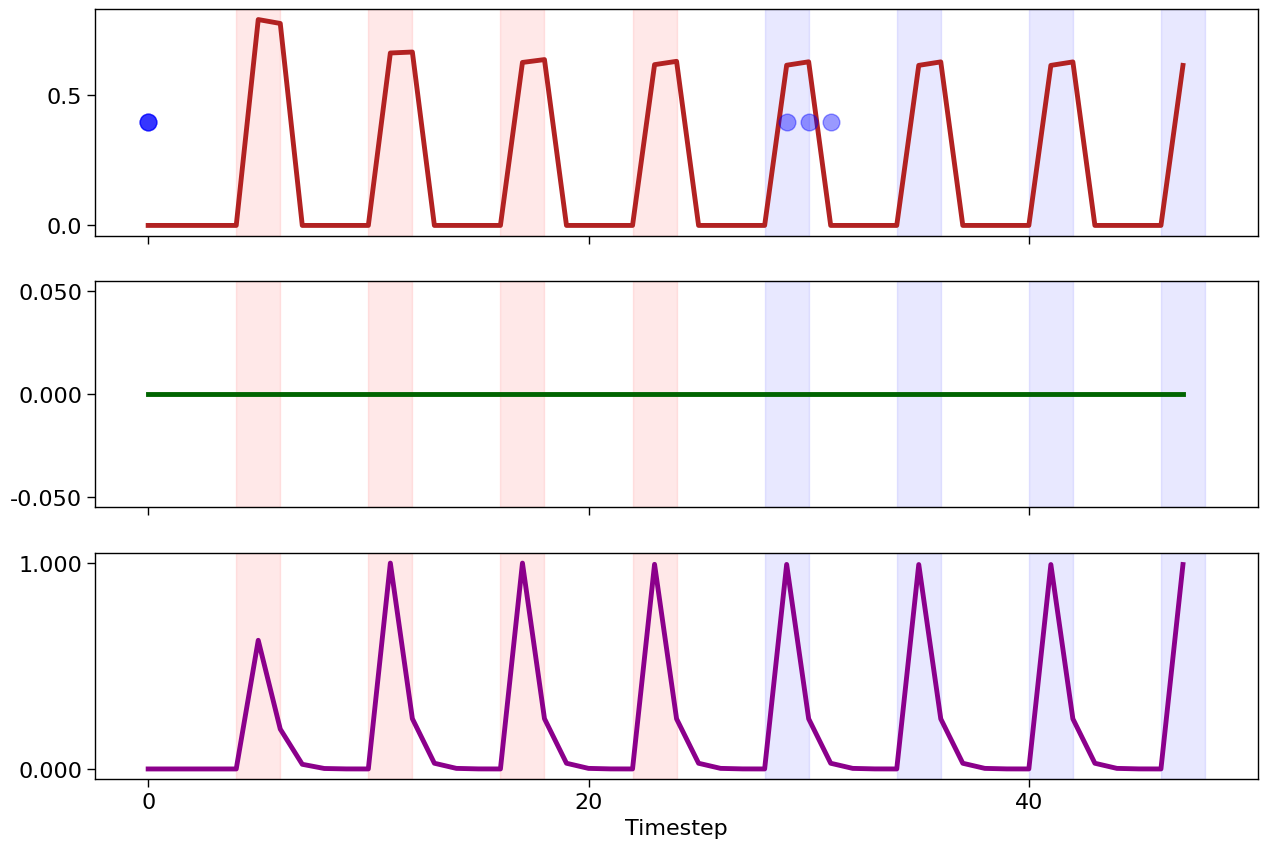

In [6]:
# example sequences (familiar)
plot_sequence_response(train_responses, train_ts, seq_idx=7, perception_only=model.perception_only)

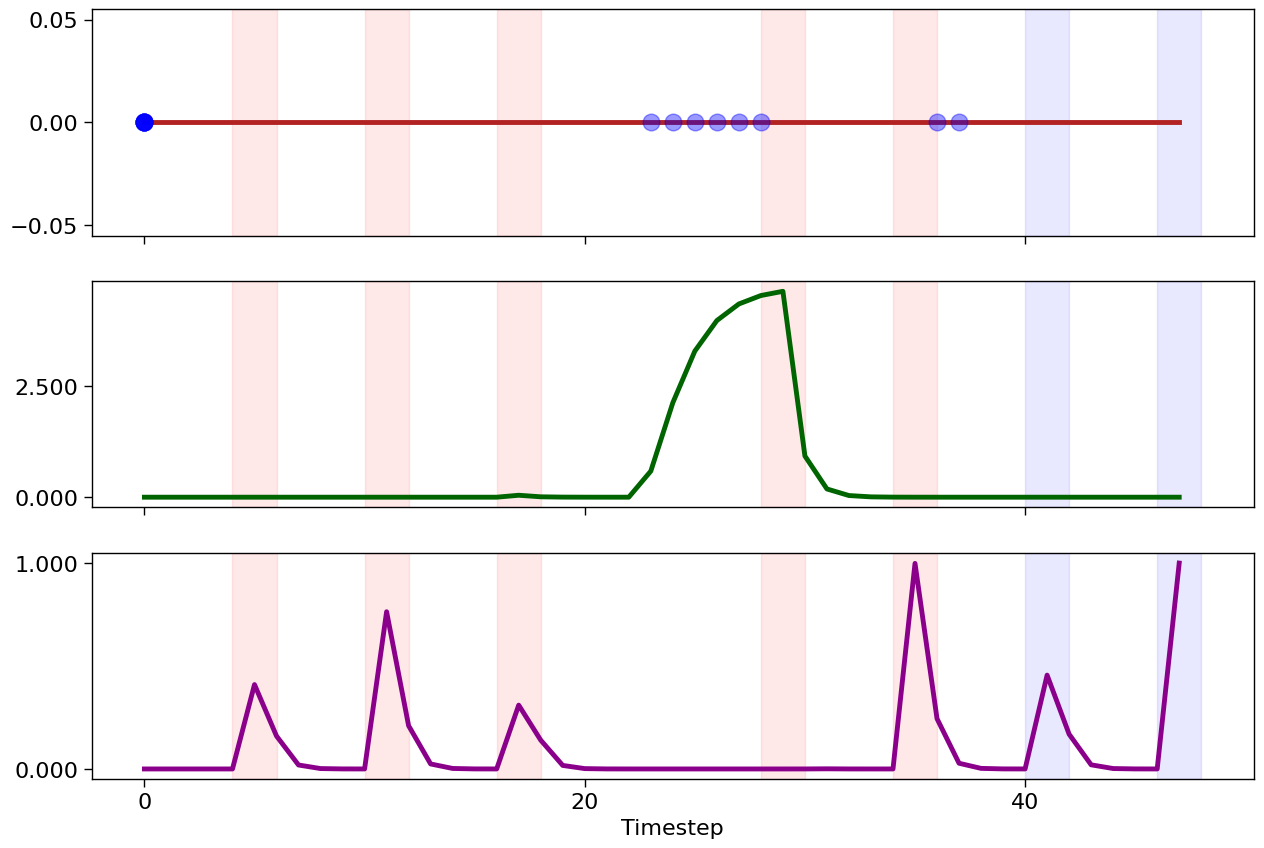

In [7]:
# example sequences (novel)
plot_sequence_response(test_responses, test_ts, seq_idx=test_om_indcs[7], perception_only=model.perception_only)

In [8]:
# get omission and change responses
change_responses, omission_responses = process_outputs(args, model, data, output, abridged=True)

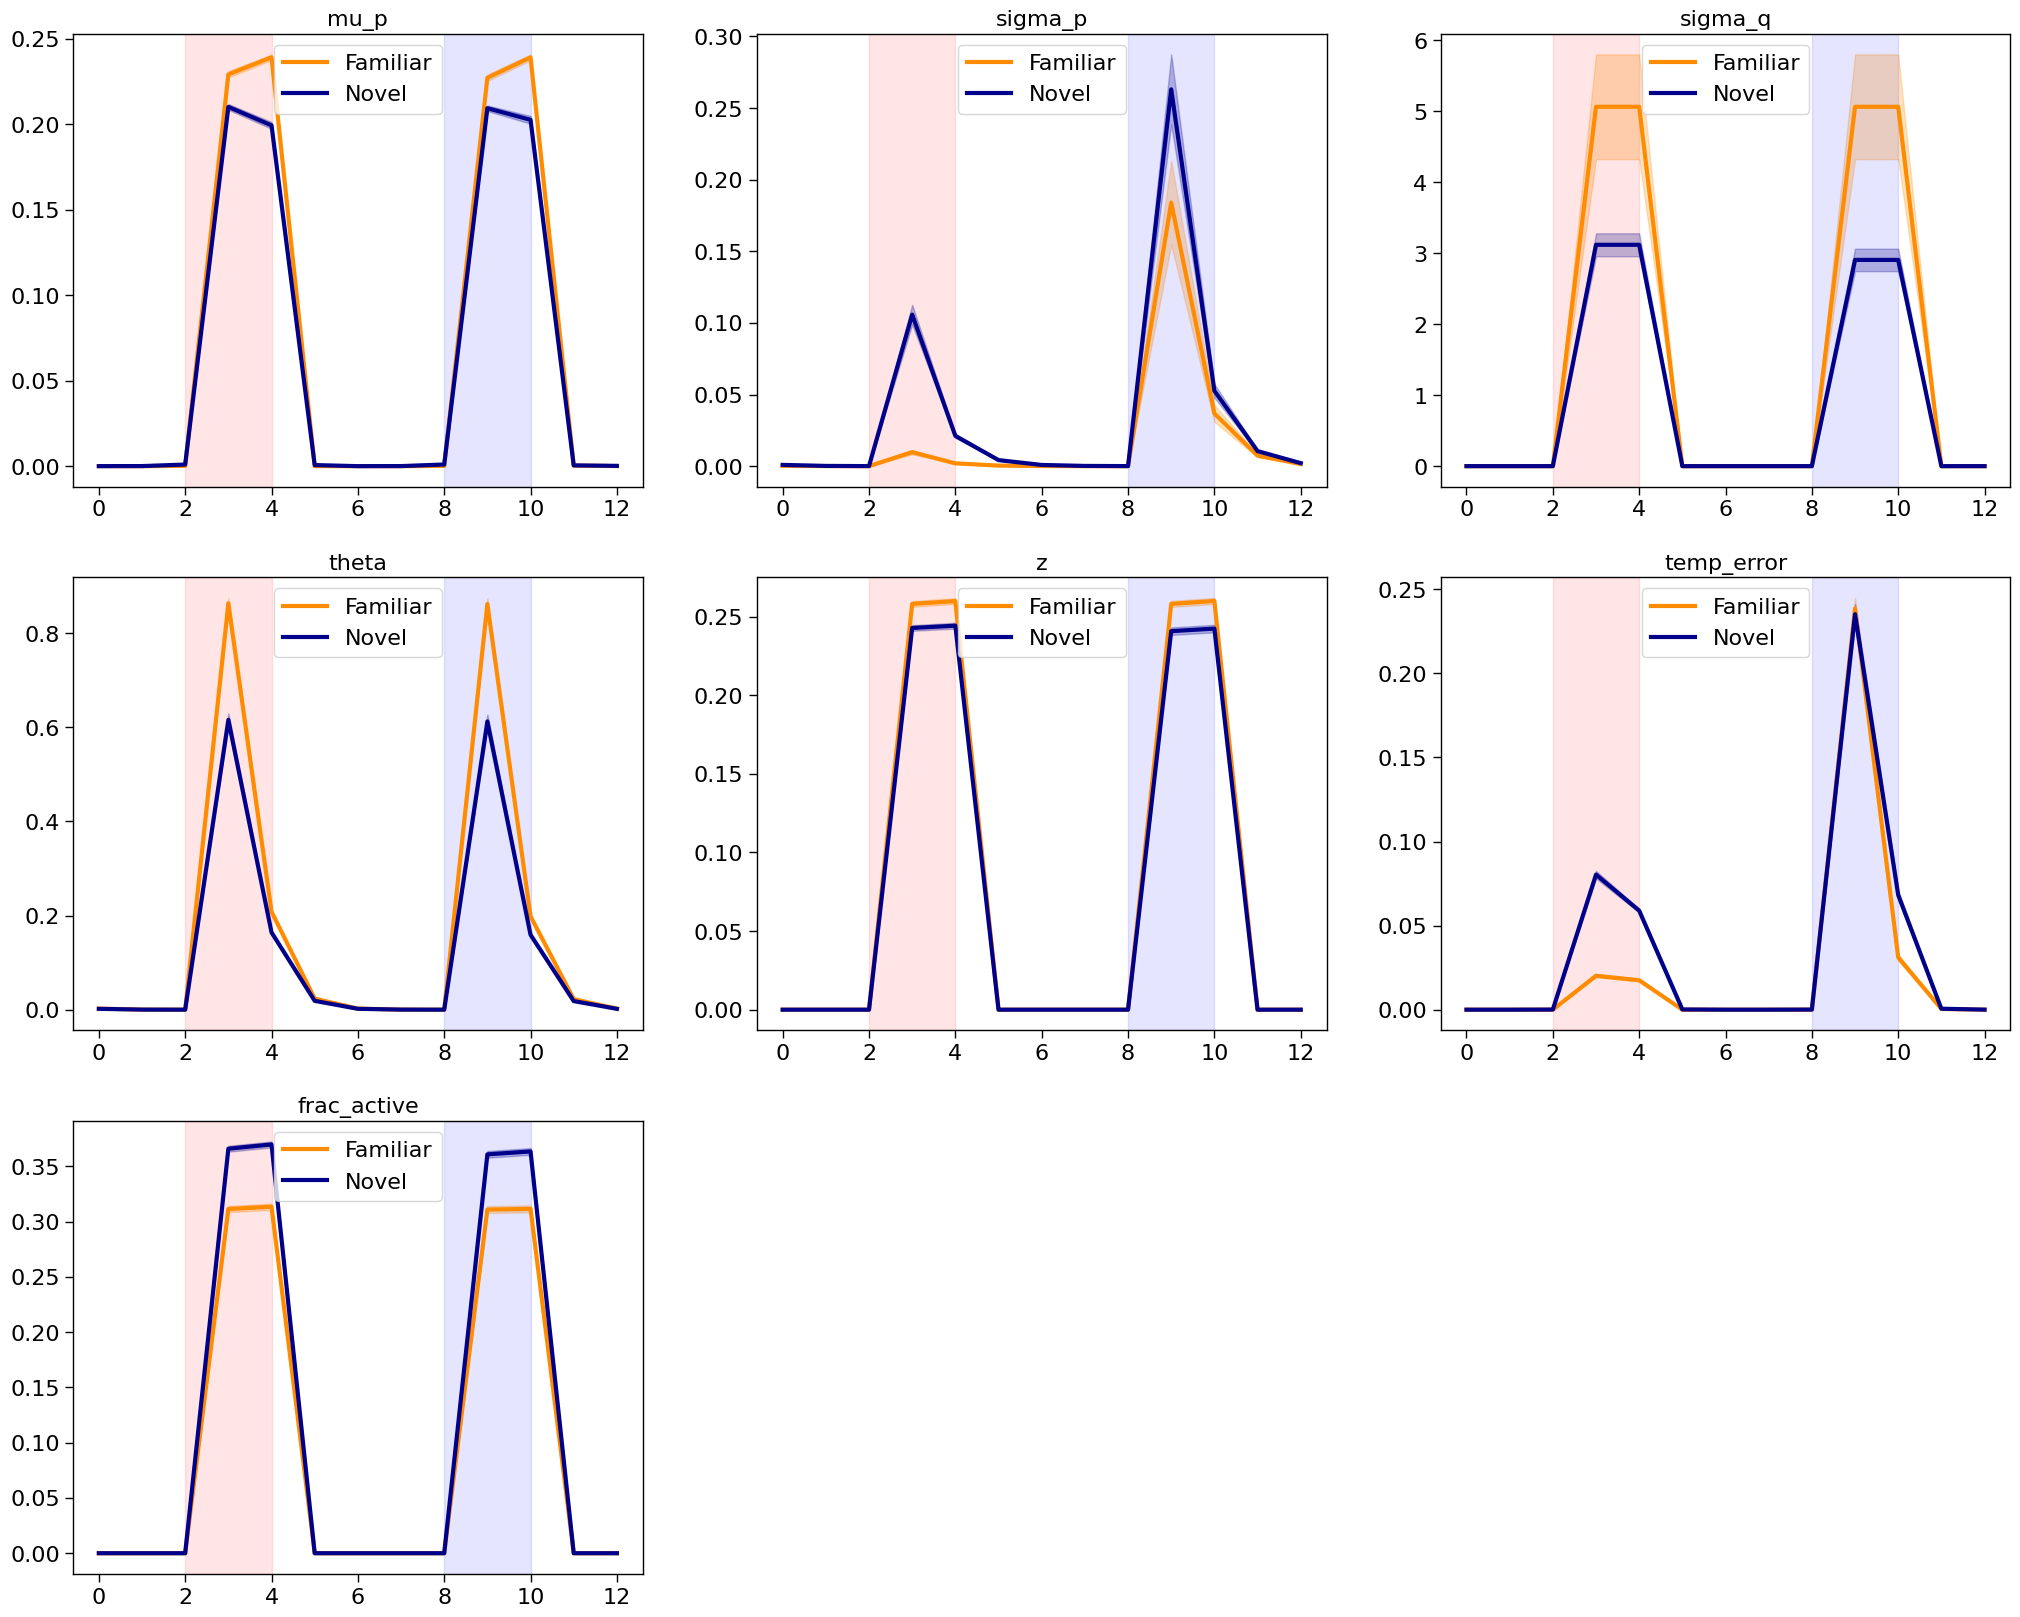

In [9]:
##### plot responses around image change

with plt.style.context(['nature', 'notebook']):

    fig3 = plt.figure(figsize=(25, 20))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(change_responses['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_change_responses(args, ax, change_responses['familiar'][pop], "Familiar", "darkorange")
        plot_change_responses(args, ax, change_responses['novel'][pop], "Novel", "darkblue")
        ax.set_title(f"{pop}")
        ax.legend()

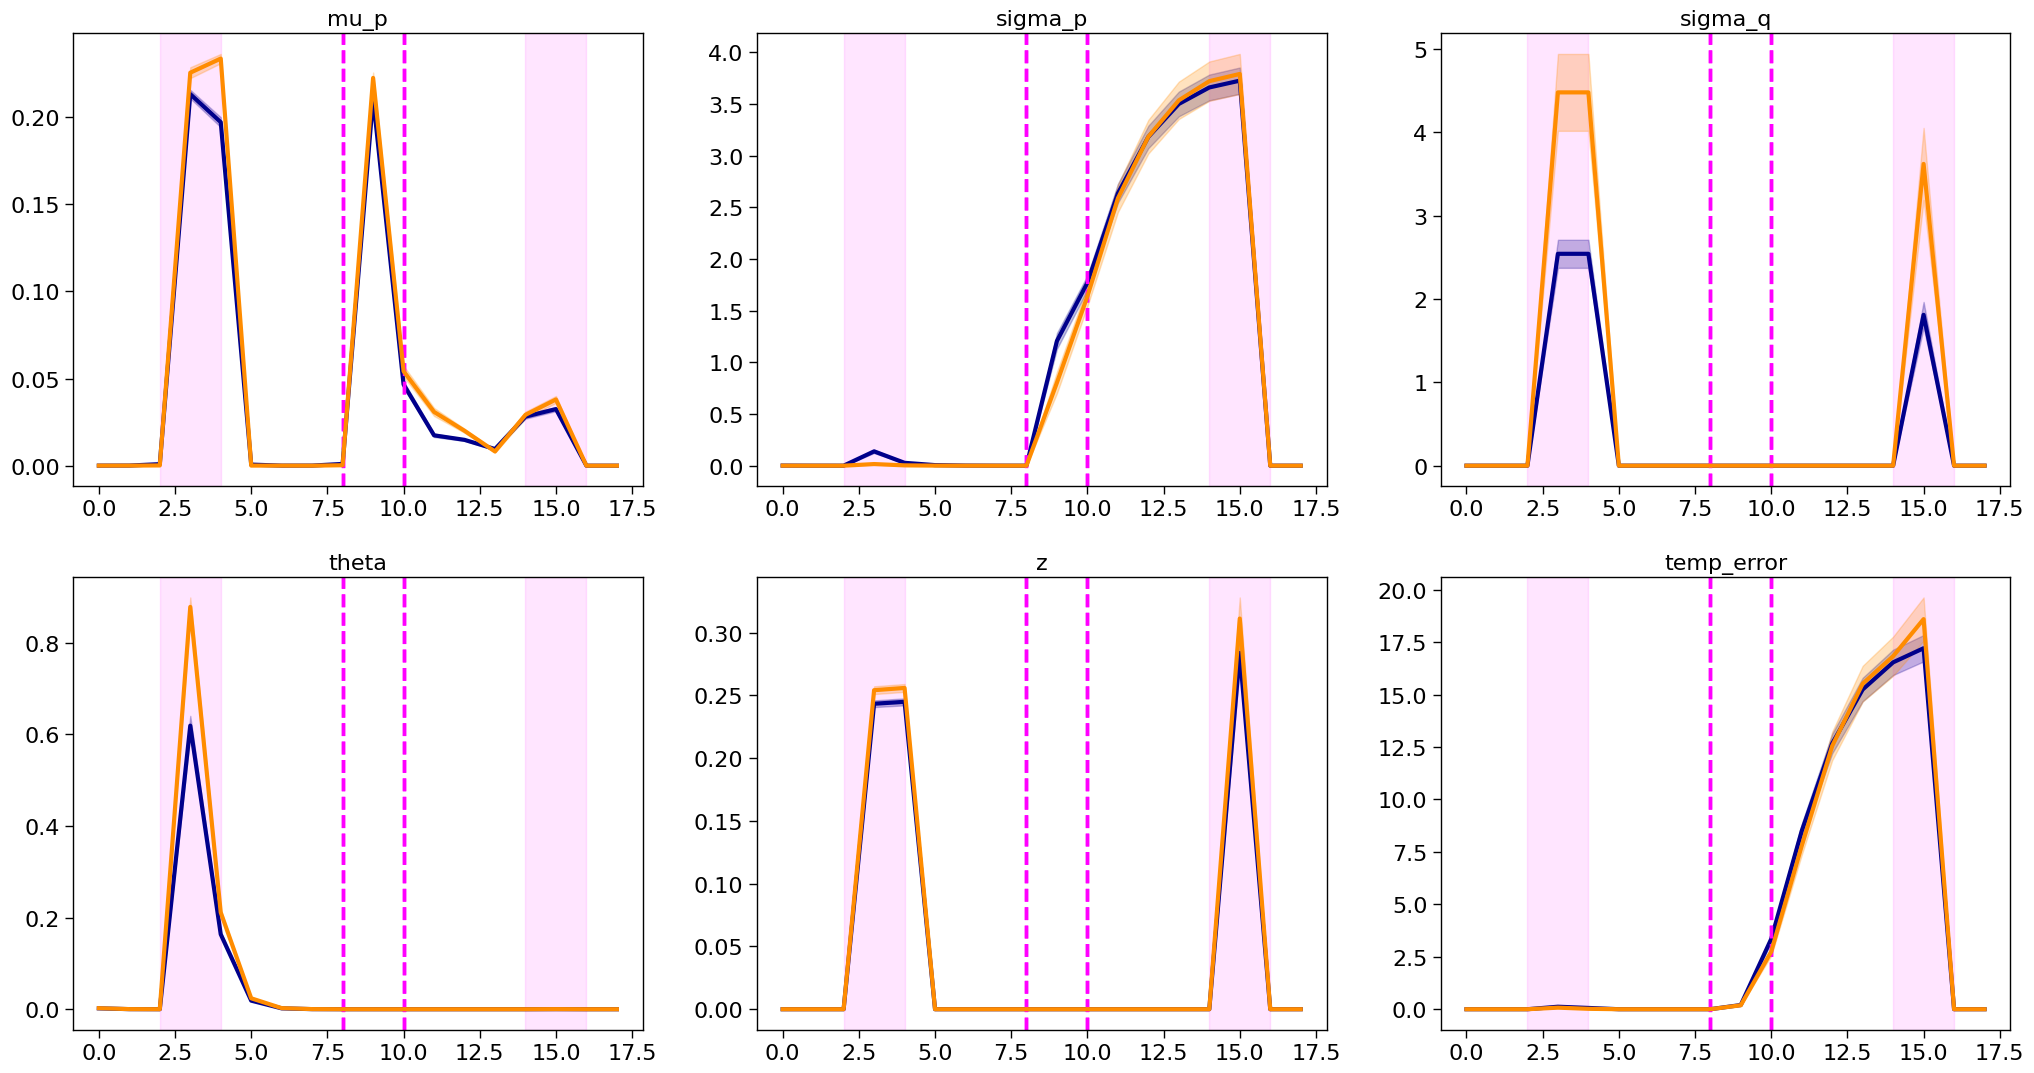

In [10]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):

    fig3 = plt.figure(figsize=(25, 20))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(omission_responses['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_omission_responses(args, ax, omission_responses['novel'][pop], "Novel", trace_clr="darkblue", image_clr="magenta", sem=True)
        plot_omission_responses(args, ax, omission_responses['familiar'][pop], "Familiar", trace_clr="darkorange", image_clr="magenta", sem=True)
        _ = ax.set_title(f"{pop}")

In [ ]:
# save
"""
save_dir = "./results/perception_only"
torch.save({
    "args": vars(args),
    "model": model.state_dict(),
    "change_responses": change_responses,
    "omission_responses": omission_responses
}, os.path.join(save_dir, f"perception_only_{seed}"))
"""